In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
train_files = glob.glob('training_data/*')

In [4]:
train_files[:10]

['training_data/dog.8136.jpg',
 'training_data/dog.10827.jpg',
 'training_data/dog.6119.jpg',
 'training_data/cat.5545.jpg',
 'training_data/cat.12080.jpg',
 'training_data/cat.1803.jpg',
 'training_data/dog.5866.jpg',
 'training_data/cat.2929.jpg',
 'training_data/cat.3141.jpg',
 'training_data/dog.1305.jpg']

In [5]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files] # for linux
#train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files] # for windows

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files] # for linux
#validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files] # for windows

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'dog', 'cat', 'cat'] [1 1 1 0 0]


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


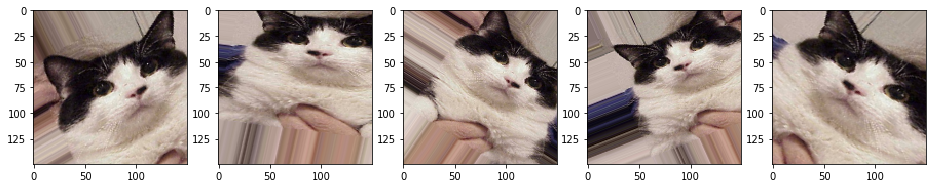

In [8]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


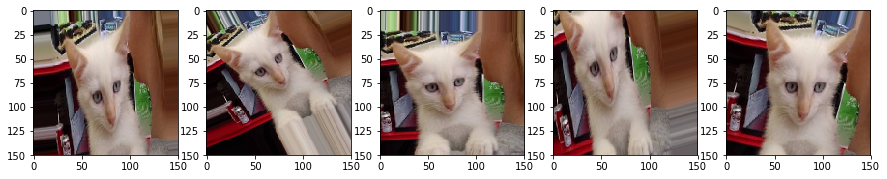

In [9]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [10]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 10s 96ms/step - loss: 0.6929 - acc: 0.5137 - val_loss: 0.6859 - val_acc: 0.5760
Epoch 2/100
100/100 [==============================] - 9s 90ms/step - loss: 0.6831 - acc: 0.5583 - val_loss: 0.6857 - val_acc: 0.5360
Epoch 3/100
100/100 [==============================] - 9s 90ms/step - loss: 0.6706 - acc: 0.5963 - val_loss: 0.6695 - val_acc: 0.5800
Epoch 4/100
100/100 [==============================] - 9s 91ms/step - loss: 0.6624 - acc: 0.5977 - val_loss: 0.6352 - val_acc: 0.6440
Epoch 5/100
100/100 [==============================] - 9s 90ms/step - loss: 0.6422 - acc: 0.6267 - val_loss: 0.6163 - val_acc: 0.6450
Epoch 6/100
100/100 [==============================] - 9s 91ms/step - loss: 0.6332 - acc: 0.6360 - val_loss: 0.6188 - val_acc: 0.6520
Epoch 7/100
100/100 [==============================] - 9s 91ms/step - loss: 0.6239 - acc: 0.6540 - val_loss: 0.5953 - val_acc: 0.6760
Epoch 8/100
1

Epoch 38/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4840 - acc: 0.7700 - val_loss: 0.5016 - val_acc: 0.7720
Epoch 39/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4652 - acc: 0.7840 - val_loss: 0.4571 - val_acc: 0.7900
Epoch 40/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4781 - acc: 0.7733 - val_loss: 0.4298 - val_acc: 0.8060
Epoch 41/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4702 - acc: 0.7857 - val_loss: 0.4993 - val_acc: 0.7890
Epoch 42/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4780 - acc: 0.7727 - val_loss: 0.4389 - val_acc: 0.7980
Epoch 43/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4701 - acc: 0.7747 - val_loss: 0.4508 - val_acc: 0.7950
Epoch 44/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4558 - acc: 0.7847 - val_loss: 0.4112 - val_acc: 0.8110
Epoch 45/100
100/100 [==============================] -

Epoch 76/100
100/100 [==============================] - 9s 91ms/step - loss: 0.3994 - acc: 0.8183 - val_loss: 0.4587 - val_acc: 0.8150
Epoch 77/100
100/100 [==============================] - 9s 91ms/step - loss: 0.4079 - acc: 0.8187 - val_loss: 0.3845 - val_acc: 0.8330
Epoch 78/100
100/100 [==============================] - 9s 90ms/step - loss: 0.3970 - acc: 0.8270 - val_loss: 0.4533 - val_acc: 0.8040
Epoch 79/100
100/100 [==============================] - 9s 91ms/step - loss: 0.3997 - acc: 0.8210 - val_loss: 0.3855 - val_acc: 0.8350
Epoch 80/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4010 - acc: 0.8220 - val_loss: 0.4009 - val_acc: 0.8190
Epoch 81/100
100/100 [==============================] - 9s 91ms/step - loss: 0.3797 - acc: 0.8300 - val_loss: 0.3728 - val_acc: 0.8400
Epoch 82/100
100/100 [==============================] - 9s 90ms/step - loss: 0.3957 - acc: 0.8197 - val_loss: 0.4041 - val_acc: 0.8290
Epoch 83/100
100/100 [==============================] -

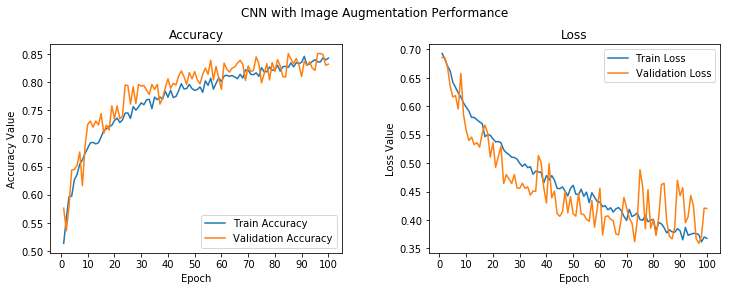

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [14]:
model.save('cats_dogs_cnn_img_aug.h5')